In [1]:
using_colab = False

In [2]:
if using_colab:

    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/mapinv_reference_data_Rosetta.xlsx'
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Mode.png'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    !pip install jupyter_bokeh

    #!unzip photos


# Reservoir Characterization: Capillary Pressure and Rock Typing

## Interrogation of the Rosetta Stone Carbonate core calibration data with Thomeer Calillary Pressure parameters used in this workflow to fully appreciate the Petrophysical Rock Types (PRT) established by Clerke.

Interrogate Rosetta Stone core calibration data using Python's Altair to create interactive plots, cross plots and histograms. Altair is one of the best interactive software python libraries that allows the user to select data from an assortment of plots and observe the selected data on other depth plots, cross plots and histograms using your own user-defined layout.


---
## Observations:
From Clerke’s Rosetta Stone Arab D carbonate dataset most macro rock typically has a dual porosity system as indicated by the Pore Throat Distribution (PTD) that has two modes as shown below: 

![Mode.png](Mode.png)

The macro portion of the rock will have a mode greater than 2 microns with a second (or third) mode less than 2 microns for the other pore systems. Probably the most abundant PRT is the M_1. This is a macro-porous rock with a mode in the macro portion of the PTD and a second mode in the meso-porosity range. In this M_1 PRT, both the macro pores and meso-porous grains can contain oil saturations once the reservoir capillary pressure is great enough to drive out the water. The M_2 PRT is also a macro porous rock, but the second pore system is micro-porous and is too tight to have hydrocarbon saturations. 


### Petrophysical Rock Typing (PRT):

**One of the benefits of working with Thomeer parameters is that the exact mode of the PTD (radius) can be calculated for each sample using the Buiting Mode equation as shown below:**

        Mode(microns) = (exp(-1.15 * G) * (214/Pd))/2
        
The above equation gives us the mode of the pore system, and we normally only calculate the mode for the largest pore system for the sample. Winlands r35 and Amaefule's FZI attept to estimate the most dominant pore throat in the rock. 

Windland's r35 is calculated:

    r35(microns) = 10**(0.732 + 0.588*log(Permeability) - 0.864*log(Porosity*100))
    
Amaefule-Kersey FZI is calculated:

    RQI(microns) = 0.0314 * sqrt(Permeability/Porosity)
    
    Phiz = Porosity / (1 - Porosity)

    FZI(microns) = RQI / Phiz
    
where Porosity is a volume fraction and not percent.
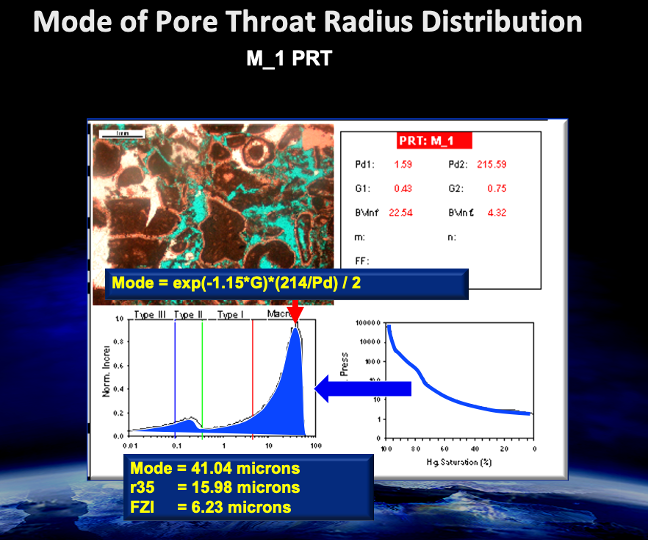

---
---

## Python Requirements:

In [3]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import altair as alt

import altair_transform
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---
## First Import Core analysis data with Thomeer Parameters from a Rosttta Stone core database:

In [4]:
#read the file
file = r'mapinv_reference_data_Rosetta.xlsx'
df_Rosetta = pd.read_excel(file,index_col=False)

In [5]:
df_Rosetta.head()

Sample  PERMEABILITY  POROSITY%    G1   PD1  G2  PD2  G3  PD3   BV1%  BV2%  \
0       1     4800.0000      25.81  0.49  1.29 NaN  NaN NaN  NaN  25.81   0.0   
1       2     1550.0000      30.05  0.69  1.55 NaN  NaN NaN  NaN  30.05   0.0   
2       3      520.9935      30.71  0.74  3.37 NaN  NaN NaN  NaN  30.71   0.0   
3       4      234.0000      22.08  0.64  4.39 NaN  NaN NaN  NaN  22.08   0.0   
4       5      432.2024      24.87  0.53  4.46 NaN  NaN NaN  NaN  24.87   0.0   

   BV3       Mode PRT  ROCK_INDEX DATA_SOURCE  POROSITY     BV1  BV2  
0  0.0  94.427637   M           1     Rosetta    0.2581  0.2581  0.0  
1  0.0  62.440936   M           1     Rosetta    0.3005  0.3005  0.0  
2  0.0  27.114354   M           1     Rosetta    0.3071  0.3071  0.0  
3  0.0  23.351163   M           1     Rosetta    0.2208  0.2208  0.0  
4  0.0  26.084134   M           1     Rosetta    0.2487  0.2487  0.0

## Calculate Capillary Pressure curves from the Thomeer parameters:

In [6]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Create HPMI Pc data from Thomeer Parameters
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

Pd1 = df_Rosetta['PD1']
G1  = df_Rosetta['G1']
BV1 = df_Rosetta['BV1']

Pd2 = df_Rosetta['PD2']
G2  = df_Rosetta['G2']
BV2 = df_Rosetta['BV2']

Pd3 = df_Rosetta['PD3']
G3  = df_Rosetta['G3']
BV3 = df_Rosetta['BV3']


k=0
Pc = 0.
BVocc_last = 0


bvarray     = []; #make list of 0 length
pcarray     = []
Sample      = []
micronarray = []
dbvarray    = []

   
for k in range (0,len(df_Rosetta)): # Sample Numbers
    
    Pc = 1.61  
    
    for j in range(1, 28, 1): # levels of Pc data
        if Pc > Pd1[k]:
            BVOCC1 = BV1[k] * 10**((-0.434 * G1[k]) / np.log10(Pc / Pd1[k]))
        else:
            BVOCC1 = 0.001

        if Pc > Pd2[k]:
            BVOCC2 = BV2[k] * 10**((-0.434 * G2[k]) / np.log10(Pc / Pd2[k]))
        else:
            BVOCC2 = 0.001


        if j  > 1:
            dBv = (BVOCC1 + BVOCC2 )  - BVocc_last
        else:
            dBv = 0
        
        BVOCC = BVOCC1 + BVOCC2 

        microns = 214/Pc            


        Sample.append(k+1)
        bvarray.append(BVOCC)  #add items 
        pcarray.append(Pc)  #add items 
        micronarray.append(microns)
        dbvarray.append(dBv)

        BVocc_last = BVOCC1 + BVOCC2 

        Pc = Pc * 1.5





## Create a DataFrame for Pc, BVocc and PTD from Thomeer Capillary Pressure parameters:

In [7]:
df_bv=pd.DataFrame(bvarray,columns=['BVOCC'])
df_pc=pd.DataFrame(pcarray, columns=['Pc'])
df_sample=pd.DataFrame(Sample, columns=['Sample'])
df_microns=pd.DataFrame(micronarray, columns=['Microns'])
df_dbv=pd.DataFrame(dbvarray, columns=['dBv'])

#index_col=False

df_Pc=pd.DataFrame()
df_Pc['Sample'] = df_sample
df_Pc['Pc']     = df_pc
df_Pc['BVOCC']  = df_bv
df_Pc['Microns'] = df_microns
df_Pc['dBv']    = df_dbv


df_Pc.head(40)

Sample            Pc     BVOCC     Microns       dBv
0        1      1.610000  0.002592  132.919255  0.000000
1        1      2.415000  0.043745   88.612836  0.041153
2        1      3.622500  0.087605   59.075224  0.043860
3        1      5.433750  0.118832   39.383483  0.031227
4        1      8.150625  0.141011   26.255655  0.022179
5        1     12.225938  0.157334   17.503770  0.016323
6        1     18.338906  0.169777   11.669180  0.012443
7        1     27.508359  0.179549    7.779453  0.009772
8        1     41.262539  0.187416    5.186302  0.007867
9        1     61.893809  0.193879    3.457535  0.006463
10       1     92.840713  0.199280    2.305023  0.005401
11       1    139.261069  0.203860    1.536682  0.004580
12       1    208.891604  0.207791    1.024455  0.003932
13       1    313.337406  0.211203    0.682970  0.003411
14       1    470.006109  0.214190    0.455313  0.002987
15       1    705.009164  0.216828    0.303542  0.002638
16       1   1057.513745  0.219173    0.202361  0.002346
17       1   1586.270618  0.221273    0.134908  0.002100
18       1   2379.405927  0.223163    0.089938  0.001890
19       1   3569.108890  0.224874    0.059959  0.001711
20       1   5353.663335  0.226429    0.039973  0.001555
21       1   8030.495003  0.227850    0.026648  0.001420
22       1  12045.742505  0.229152    0.017766  0.001302
23       1  18068.613757  0.230350    0.011844  0.001198
24       1  27102.920636  0.231456    0.007896  0.001106
25       1  40654.380953  0.232481    0.005264  0.001024
26       1  60981.571430  0.233432    0.003509  0.000951
27       2      1.610000  0.001000  132.919255  0.000000
28       2      2.415000  0.009373   88.612836  0.008373
29       2      3.622500  0.047301   59.075224  0.037927
30       2      5.433750  0.085751   39.383483  0.038450
31       2      8.150625  0.116458   26.255655  0.030707
32       2     12.225938  0.140309   17.503770  0.023851
33       2     18.338906  0.159041   11.669180  0.018731
34       2     27.508359  0.174026    7.779453  0.014985
35       2     41.262539  0.186238    5.186302  0.012213
36       2     61.893809  0.196360    3.457535  0.010122
37       2     92.840713  0.204875    2.305023  0.008515
38       2    139.261069  0.212130    1.536682  0.007256
39       2    208.891604  0.218383    1.024455  0.006253

## Join both datasets where the Thomeer parameters are repeated for each Pc value in each Sample:

In [8]:
# reading the files
f1 = df_Pc
f2 = df_Rosetta

# merging the files
df = f1.join(f2.set_index('Sample'),on='Sample')
df.head()

Sample        Pc     BVOCC     Microns       dBv  PERMEABILITY  POROSITY%  \
0       1  1.610000  0.002592  132.919255  0.000000        4800.0      25.81   
1       1  2.415000  0.043745   88.612836  0.041153        4800.0      25.81   
2       1  3.622500  0.087605   59.075224  0.043860        4800.0      25.81   
3       1  5.433750  0.118832   39.383483  0.031227        4800.0      25.81   
4       1  8.150625  0.141011   26.255655  0.022179        4800.0      25.81   

     G1   PD1  G2  ...   BV1%  BV2%  BV3       Mode  PRT  ROCK_INDEX  \
0  0.49  1.29 NaN  ...  25.81   0.0  0.0  94.427637    M           1   
1  0.49  1.29 NaN  ...  25.81   0.0  0.0  94.427637    M           1   
2  0.49  1.29 NaN  ...  25.81   0.0  0.0  94.427637    M           1   
3  0.49  1.29 NaN  ...  25.81   0.0  0.0  94.427637    M           1   
4  0.49  1.29 NaN  ...  25.81   0.0  0.0  94.427637    M           1   

   DATA_SOURCE POROSITY     BV1  BV2  
0      Rosetta   0.2581  0.2581  0.0  
1      Rosetta   0.2581  0.2581  0.0  
2      Rosetta   0.2581  0.2581  0.0  
3      Rosetta   0.2581  0.2581  0.0  
4      Rosetta   0.2581  0.2581  0.0  

[5 rows x 23 columns]

---
# Interactive Altair plots to interrogate the Rosetta Stone dataset

## Example of viewing Capillary Pressure (Pc) Curves and Thomeer Pc Parameters according to the sample's position in Poro-Perm Space:

This eample gives us an idea of the magnitude of the Thomeer parameters from a narrow range of selected samples from the porosity-permeability cross plot. In our typical workflow we actually estimate the appropriate Thomeer parameters using Knn from the 3-5 nearest neighbors, but the following plot provides a visualization of appropriate Thomeer parameters for a selected group of samples.


In [9]:
interval = alt.selection_interval()

base = alt.Chart(df).properties(
    width=300,
    height=375, 
).add_selection(interval)


#------------------------------------------------
#
#       Poro-Perm Cross Plot
#
#------------------------------------------------

kphi = alt.Chart(df).mark_point(filled=True, size=100).encode(
    #x='Porosity:Q',
    #y='lPerm:Q',

    alt.X('POROSITY:Q',
        scale=alt.Scale(domain=(0, 0.35))
    ),    
    alt.Y('PERMEABILITY:Q',scale=alt.Scale(type='log', base=10,domain=(.0001, 10000))),
    #size='lMode:Q',
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('lightgray'),
                        scale=alt.Scale(
                        domain=[ 1,         2,         3,      4,      5,        6   ],
                        range =['cyan', 'dodgerblue','blue','yellow','orange','brown'])),
    tooltip='Mode:Q', 
).properties(
    width=400,
    height=500, 

    title='Porosity vs. Permeability Cross Plot (PRT on Color Axis)',
    selection=interval
)


#------------------------------------------------
#
#       Capillary Pressure Curves colored by PRT
#
#------------------------------------------------
pc = alt.Chart(df).mark_line(clip=True).encode(
    alt.X('BVOCC:Q',
        scale=alt.Scale(domain=(0.30, 0))
    ),    
    alt.Y('Pc:Q',scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('lightgray'),scale=alt.Scale(scheme='rainbow')),
    tooltip='Mode:Q', 
    strokeDash='Sample:N',
).properties(
    title='Pc Curves with PRT on Color Axis (Upscaled Pc curve is thick Black Curve)',
    width=400,
    height=500, 
    
).transform_filter(
    interval
)

pc2 = alt.Chart(df).mark_line(clip=True,strokeWidth=6).encode(
    alt.X('BVOCC:Q', aggregate='mean',
          scale=alt.Scale(domain=(0.30, 0))
         ),
    alt.Y('Pc:Q',scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    color=alt.value('black'),
).properties(
    #title='Upscaled Pc Curve with PRT as Color Axis',
    width=400,
    height=500, 
    
).transform_filter(
    interval
)
    
#------------------------------------------------
#
#       Pore Throat Distributions
#
#------------------------------------------------
ptd2 = base.mark_line( clip=True).encode(
    alt.X('Microns:Q',
        scale=alt.Scale(type='log', base=10,domain=(.01, 100))
    ),    
    alt.Y('dBv:Q',
        scale=alt.Scale(domain=(0, 0.15))
    ),    
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('lightgray'),scale=alt.Scale(scheme='rainbow')),
    strokeDash='Sample:N',
).properties(
    title='Pore Throat Distribution (Microns)',
    width=400,
    height=125,
).transform_filter(
    interval
)


ptd2b = base.mark_line( clip=True).encode(
    alt.X('Microns:Q',
        scale=alt.Scale(type='log', base=10,domain=(.01, 100))
    ),    
    alt.Y('dBv:Q',aggregate='mean',
        scale=alt.Scale(domain=(0, 0.001))
    ),    
     color=alt.value('black'),
    #strokeDash='Sample:N',
).properties(
    title='Pore Throat Distribution (Microns)',
    width=400,
    height=125,
).transform_filter(
    interval
)



#------------------------------------------------
#
#       Various Other Histograms
#
#------------------------------------------------
hist_pd1 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('PD1',scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 30))),    
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('lightgreen'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='Pd1 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)

hist_pd1b = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('PD1', aggregate='median', scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    #x='rock_index:O',
    #y='lmode:Q', 
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.value('black'),
    #strokeDash='Sample:N'
).properties(
    title='Pd1 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)



hist_pd2 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('PD2',scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    #x='rock_index:O',
    #y='lmode:Q',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    #y='count()',
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('green'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='Pd2 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)


hist_pd2b = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('PD2', aggregate='median', scale=alt.Scale(type='log', base=10,domain=(1, 10000))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.value('black'),
    #strokeDash='Sample:N'
).properties(
    title='Pd2 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)




hist_g1 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('G1',scale=alt.Scale(domain=(0, 2))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('orange'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='G1 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)

hist_g1b = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('G1',aggregate='median',scale=alt.Scale(domain=(0, 2))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.value('black'),
    #strokeDash='Sample:N'
).properties(
    title='G1 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)





hist_g2 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('G2',scale=alt.Scale(domain=(0, 2))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('brown'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='G2 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)
hist_g2b = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('G2',aggregate='median',scale=alt.Scale(domain=(0, 2))),
    #x='rock_index:O',
    #y='lmode:Q',
    #y='count()',
    alt.Y('count()',scale=alt.Scale(domain=(0, 40))),
    color=alt.value('black'),
    #strokeDash='Sample:N'
).properties(
    title='G2 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)



hist_bv1 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('BV1',scale=alt.Scale(domain=(0, 30))),
    #x='rock_index:O',
    #y='lmode:Q',
    y='count()',
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('cyan'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='BV1 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)

hist_bv2 = alt.Chart(df).mark_bar(clip=True).encode(
    alt.X('BV2',scale=alt.Scale(domain=(0, 30))),
    #x='rock_index:O',
    #y='lmode:Q',
    y='count()',
    color=alt.condition(interval, 'ROCK_INDEX:O', alt.value('blue'),scale=alt.Scale(scheme='rainbow')),
    #strokeDash='Sample:N'
).properties(
    title='BV2 of Selected Samples',
    width=400,
    height=125,
    #selection=interval
).transform_filter(
    interval
)

#------------------------------------------------
#
#       Define Plot Regions for Altair
#
#------------------------------------------------

kphihist = kphi | pc + pc2
poresys1 = hist_pd1 + hist_pd1b | hist_g1 + hist_g1b 
poresys2 = hist_pd2+hist_pd2b   | hist_g2 + hist_g2b 

plot = kphihist & poresys1 & ptd2 & poresys2 


plot



alt.VConcatChart(...)